In [1]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics
from asap.annotation import ASAPNMF
import asapc
import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc
from sklearn.preprocessing import StandardScaler
# import logging


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id



tree_max_depth = 8
num_factors = 10
batch_size = 10000
batch_iteration = 1
downsample_pseudobulk = False
downsample_size = 100

dl = DataSet(sample_in,sample_out)
sample_list = dl.get_samplenames()
dl.initialize_data(sample_list,batch_size)

print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/pbmc/pbmc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/pbmc/pbmc


In [2]:
model = np.load(sample_out+'_pobc_dcnmf.npz')

In [3]:
len(pd.Series(dl.genes).unique())

35989

In [4]:
df_beta = pd.DataFrame(model['beta'].T)
# df_beta.columns = [x for x in dl.genes]
df_theta = pd.DataFrame(model['corr'])
df_theta.index = dl.barcodes

In [5]:
df_beta.shape

(10, 36511)

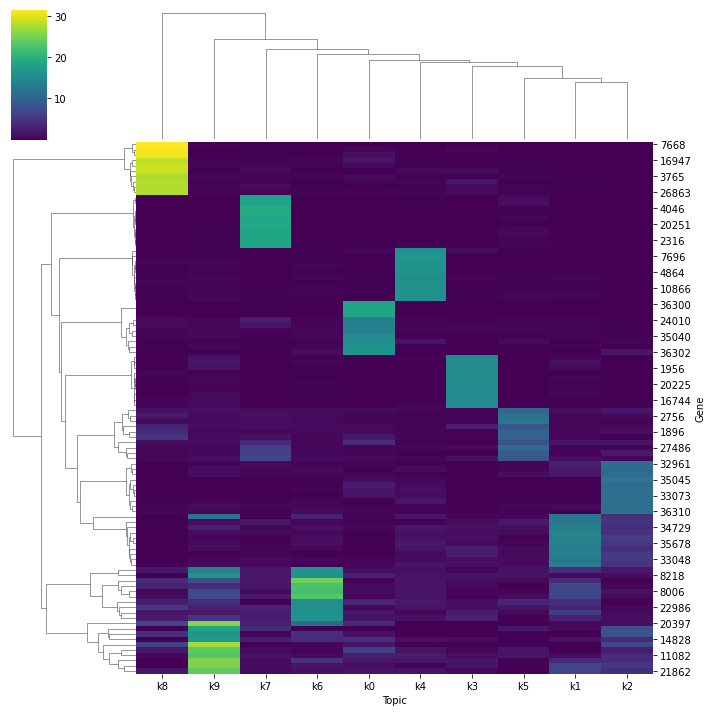

In [6]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [7]:
df_top

Gene,1722,1896,1955,1956,2128,2146,2316,2717,2756,3615,...,35044,35045,35046,35348,35678,35834,36300,36302,36310,36362
Topic,,,,,,,,,,,,,,,,,,,,,
k0,0.119541,0.822543,0.003815,0.008818,0.218494,0.025685,0.059745,0.117760,0.459607,0.496893,...,18.475063,0.936060,2.416669,0.404157,0.101829,0.882650,18.549524,15.890606,0.705065,0.412342
k1,0.025778,0.503465,0.999924,0.898987,0.120701,0.444844,0.121958,0.134926,0.572596,0.288835,...,0.034108,0.050068,0.034113,12.692348,14.044601,0.999842,0.017002,0.013811,0.212425,13.163777
k2,0.013950,1.199326,0.030496,0.031786,0.066886,0.027815,0.100240,0.042778,0.864394,2.047596,...,0.011196,12.451023,11.046977,4.346012,5.108221,1.760534,0.003555,1.800370,11.646387,4.664187
k3,0.913799,0.268079,15.074827,15.219630,0.068254,15.133584,0.047431,0.894122,0.307889,0.081065,...,0.012080,0.017181,0.009191,0.586630,0.799255,0.310565,0.002512,0.003974,0.086110,1.291383
k4,0.640266,0.359431,0.000847,0.007817,16.216743,0.263499,0.086364,0.223285,0.317561,0.136397,...,0.014370,0.502575,0.980866,1.800750,1.858723,0.556296,0.003586,0.006686,0.279057,1.784162
k5,0.158610,9.765556,0.006866,0.011382,0.073402,0.028820,0.294603,0.319607,11.506288,9.267197,...,0.023671,0.017480,0.013931,0.469665,0.481152,10.177364,0.008966,0.005487,0.363520,0.953564
k6,0.044573,0.763405,0.475475,0.111092,0.274797,0.173828,0.194823,0.161133,0.882687,0.685287,...,0.040585,0.196835,0.108654,2.999390,1.206791,0.873712,0.007026,0.921592,0.746637,0.165091
k7,0.716638,0.578993,0.011312,0.007838,0.058819,0.012140,18.434303,0.901445,1.123860,6.050891,...,0.021252,0.016005,0.016192,0.029112,0.139673,0.897426,0.136773,0.004875,0.161250,0.494771
k8,28.917137,3.720746,0.003890,0.009106,0.241996,0.036133,0.104208,27.760309,2.058985,0.419963,...,0.021873,0.028131,0.017436,0.002219,0.067369,1.287411,0.002950,0.007189,0.303065,0.032939


In [8]:
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_umap= pd.DataFrame()
df_umap['cell'] = dl.barcodes
# df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

scaler = StandardScaler()
scaled = scaler.fit_transform(df_theta.to_numpy())
kmeans = KMeans(n_clusters=10, init='k-means++',random_state=0).fit(scaled)
df_umap['topic_bulk'] = kmeans.labels_

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.4,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,umap1,umap2
0,AAACATACAACCAC-1_3k_3k,3,15.363107,5.922553
1,AAACATTGAGCTAC-1_3k_3k,9,13.580038,9.058736
2,AAACATTGATCAGC-1_3k_3k,8,13.298612,2.161674
3,AAACCGTGCTTCCG-1_3k_3k,5,7.207986,20.200777
4,AAACCGTGTATGCG-1_3k_3k,7,10.661308,-1.534953
...,...,...,...,...
7035,TTTGGTTTCGCTAGCG-1_4k_4k,1,-3.626667,-0.448113
7036,TTTGTCACACTTAACG-1_4k_4k,2,4.423753,3.674572
7037,TTTGTCACAGGTCCAC-1_4k_4k,0,2.059001,7.819314
7038,TTTGTCAGTTAAGACA-1_4k_4k,6,4.742584,-7.161175


In [ ]:
df_theta

Text(0, 0.5, 'UMAP2')

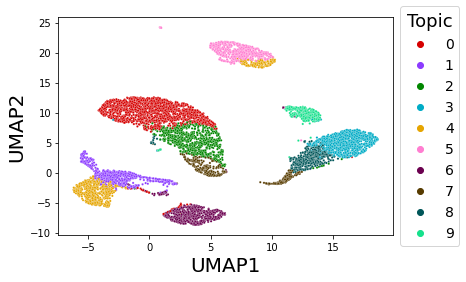

In [9]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

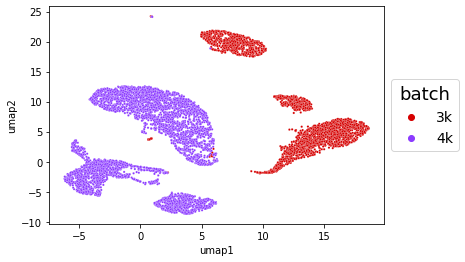

In [10]:
df_umap['batch'] = [x.split('_')[1]for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['batch'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='batch',s=5,palette=cp,legend=True)
plt.legend(title='batch',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [11]:
df_pl = pd.read_csv(dl.outpath+'_scanpy.csv.gz')
df_pl = df_pl[['cell','leiden']]
# df_pl = df_pl.loc[:,['Unnamed: 0','celltype_major']]
df_pl.columns = ['cell','cell_type']
df_pl['cell'] = [x.split('_')[0] for x in df_umap['cell']]
df_umap['cell'] = [x.split('_')[0] for x in df_umap['cell']]
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
df_umap

,cell,topic_bulk,umap1,umap2,batch,cell_type
0,AAACATACAACCAC-1,3,15.363107,5.922553,3k,0
1,AAACATTGAGCTAC-1,9,13.580038,9.058736,3k,2
2,AAACATTGATCAGC-1,8,13.298612,2.161674,3k,1
3,AAACCGTGCTTCCG-1,5,7.207986,20.200777,3k,5
4,AAACCGTGTATGCG-1,7,10.661308,-1.534953,3k,6
...,...,...,...,...,...,...
7035,TTTGGTTTCGCTAGCG-1,1,-3.626667,-0.448113,4k,3
7036,TTTGTCACACTTAACG-1,2,4.423753,3.674572,4k,6
7037,TTTGTCACAGGTCCAC-1,0,2.059001,7.819314,4k,6
7038,TTTGTCAGTTAAGACA-1,6,4.742584,-7.161175,4k,2


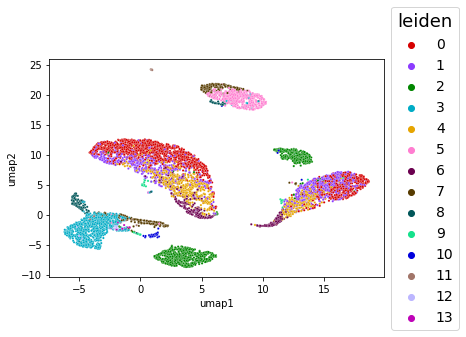

In [12]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=5,palette=cp,legend=True)
plt.legend(title='leiden',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match

In [ ]:
sns.clustermap(df_match)

In [ ]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)